In [ ]:
import pandas as pd
import requests
import zipfile
import io
from tqdm.notebook import tqdm

In [ ]:
# Step 1: Download the ZIP file with progress bar
url = 'https://gss.norc.org/content/dam/gss/get-the-data/documents/stata/GSS_stata.zip'

# Make a streaming request to get the content in chunks
response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))  # Get the total file size
block_size = 1024  # 1 Kilobyte

# Progress bar for downloading
tqdm_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
content = io.BytesIO()

# Download the file in chunks with progress bar
for data in response.iter_content(block_size):
    tqdm_bar.update(len(data))
    content.write(data)

tqdm_bar.close()

# Check if the download is successful
if total_size != 0 and tqdm_bar.n != total_size:
    print("Error in downloading the file.")
else:
    print("Download completed!")

# Step 2: Extract the ZIP file in memory and display progress
with zipfile.ZipFile(content) as z:
    # List all files in the zip
    file_list = z.namelist()

    # Filter for the .dta file (assuming there is only one)
    stata_files = [file for file in file_list if file.endswith('.dta')]

    # If there is a Stata file, proceed to extract and read it
    if stata_files:
        stata_file = stata_files[0]  # Take the first .dta file
        with z.open(stata_file) as stata_file_stream:
            # Step 3a: Load only the selected columns into a pandas DataFrame with numeric labels
            columns_to_load = [ 'age', 'hrs1', 'rincome', 'agewed' ]
            print("Loading selected columns from Stata file with numeric labels...")
            df_numeric = pd.read_stata(stata_file_stream, columns=columns_to_load, convert_categoricals=False)
            print("Data with numeric labels loaded successfully!")

        # Reload the dataset to get categorical (string) labels
        with z.open(stata_file) as stata_file_stream:
            print("Loading selected columns from Stata file with string (categorical) labels...")
            df_categorical = pd.read_stata(stata_file_stream, columns=columns_to_load)
            print("Data with categorical labels loaded successfully!")

            # Step 3b: Rename the categorical columns by prefixing with 'z' (no period)
            df_categorical = df_categorical.rename(columns={col: f'z{col}' for col in df_categorical.columns})

# Step 4: Concatenate the numeric and categorical DataFrames side by side
df = pd.concat([df_numeric, df_categorical], axis=1)

# Step 5: Display the first few rows of the final DataFrame
df.head()

  0%|          | 0.00/81.9M [00:00<?, ?iB/s]

Download completed!
Loading selected columns from Stata file with numeric labels...
Data with numeric labels loaded successfully!
Loading selected columns from Stata file with string (categorical) labels...


<ipython-input-2-0a69cc001afa>:47: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df_categorical = pd.read_stata(stata_file_stream, columns=columns_to_load)


Data with categorical labels loaded successfully!


,age,hrs1,rincome,agewed,zage,zhrs1,zrincome,zagewed
0,23.0,NaN,NaN,NaN,23.0,NaN,NaN,NaN
1,70.0,NaN,NaN,21.0,70.0,NaN,NaN,21.0
2,48.0,NaN,NaN,20.0,48.0,NaN,NaN,20.0
3,27.0,NaN,NaN,24.0,27.0,NaN,NaN,24.0
4,61.0,NaN,NaN,22.0,61.0,NaN,NaN,22.0


In [ ]:
# Step 1: Drop observations with NA values in any variable listed
df_clean = df.dropna(subset=['age', 'hrs1', 'rincome', 'agewed'])
df_clean.head()

,age,hrs1,rincome,agewed,zage,zhrs1,zrincome,zagewed
3118,41.0,65.0,10.0,22.0,41.0,65.0,"$15,000 to $19,999",22.0
3123,48.0,55.0,11.0,24.0,48.0,55.0,"$20,000 to $24,999",24.0
3126,54.0,15.0,2.0,19.0,54.0,15.0,"$1,000 to $2,999",19.0
3132,23.0,40.0,7.0,18.0,23.0,40.0,"$7,000 to $7,999",18.0
3142,59.0,52.0,9.0,30.0,59.0,52.0,"$10,000 to $14,999",30.0


In [ ]:
import pandas as pd


# Recode age directly into the existing column
df_clean['age'] = df_clean['age'].apply(lambda age: 'Young' if age <= 30 else ('Middle-aged' if 31 <= age < 55 else 'Old'))

# Recode hours worked directly into the existing column
df_clean['hrs1'] = df_clean['hrs1'].apply(lambda hrs1: 'Short' if hrs1 < 21 else ('Medium' if 21 <= hrs1 <= 50 else 'Long'))

df_clean.head()


<ipython-input-4-519b004990af>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['age'] = df_clean['age'].apply(lambda age: 'Young' if age <= 30 else ('Middle-aged' if 31 <= age < 55 else 'Old'))
<ipython-input-4-519b004990af>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['hrs1'] = df_clean['hrs1'].apply(lambda hrs1: 'Short' if hrs1 < 21 else ('Medium' if 21 <= hrs1 <= 50 else 'Long'))


,age,hrs1,rincome,agewed,zage,zhrs1,zrincome,zagewed
3118,Middle-aged,Long,10.0,22.0,41.0,65.0,"$15,000 to $19,999",22.0
3123,Middle-aged,Long,11.0,24.0,48.0,55.0,"$20,000 to $24,999",24.0
3126,Middle-aged,Short,2.0,19.0,54.0,15.0,"$1,000 to $2,999",19.0
3132,Young,Medium,7.0,18.0,23.0,40.0,"$7,000 to $7,999",18.0
3142,Old,Long,9.0,30.0,59.0,52.0,"$10,000 to $14,999",30.0


The variables I chose are age and hours worked per week (hrs1). Both variables are continuous and initially showed the real age and hours worked in each row. However, I have now recoded the data so that it splits the ages and hours worked per week of the respondents into three categories. I also removed NA values to make things cleaner. The categories for age are 'young', 'middle-aged', and 'old'. The categories for hrs1 are 'short', 'medium', and 'long'. What we want to see is whether there is a correlation between age and hours worked per week.

In [ ]:
#cross tabulation of both newly recoded variables

df_clean['age'] = pd.Categorical(df_clean['age'], categories=['Young', 'Middle-aged', 'Old'], ordered=True)

# Cross-tabulation of both newly recoded variables
crosstab_result = pd.crosstab(df_clean['age'], df_clean['hrs1'])

# Display the cross-tabulation
print(crosstab_result)


hrs1         Long  Medium  Short
age                             
Young         342    1877    191
Middle-aged  1338    5655    549
Old           259    1589    318


<ipython-input-67-5a50c3828aca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['age'] = pd.Categorical(df_clean['age'], categories=['Young', 'Middle-aged', 'Old'], ordered=True)


If I break this cross-tabulation down by category, we see that the highest frequency of respondents working long hours belong in the middle-age category, and this is also the case for the medium and short hour levels.

This may be influenced by the demographic composition of the dataset, as a larger proportion of middle-aged individuals may lead to skewed results. It is also worth considering that societal and economic factors often require middle-aged individuals to maintain stable employment, potentially resulting in longer work hours.

We also notice that the medium category for hours has the highest proportion of people, which is not surprising but since most people probably work between the 21 to 50 hour range. It's also because the difference in number of hours between each threshold I defined is not the same. Something to consider for the future but in this case it doesn't really affect the interpretation.

In [ ]:
from scipy.stats import pearsonr, spearmanr

df_clean['age'] = df_clean['age'].replace({'Young': 1, 'Middle-aged': 2, 'Old': 3})

pearson_corr, _ = pearsonr(df_clean['age'], df_clean['rincome'])
print(f'Pearson correlation: {pearson_corr}')

# Calculate Spearman correlation
spearman_corr, _ = spearmanr(df_clean['age'], df_clean['rincome'])
print(f'Spearman correlation: {spearman_corr}')

Pearson correlation: 0.07531234411420677
Spearman correlation: 0.10430520586399654


<ipython-input-68-7183c8cff2a9>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['age'] = df_clean['age'].replace({'Young': 1, 'Middle-aged': 2, 'Old': 3})
<ipython-input-68-7183c8cff2a9>:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_clean['age'] = df_clean['age'].replace({'Young': 1, 'Middle-aged': 2, 'Old': 3})
<ipython-input-68-7183c8cff2a9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

The good thing about these two variables is that that since they are ordinal, there isn't really any recoding needed. If they were categorical on the other hand, we would have to convert them to an ordinal nature so that the pearson and spearman correlation code would work.

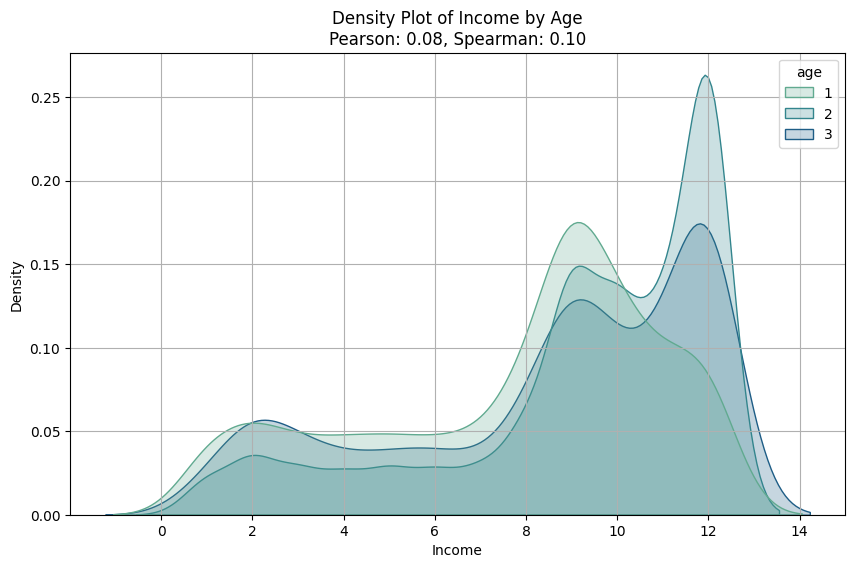

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean, x='rincome', hue='age', common_norm=False, fill=True, palette='crest')

# Calculate and display Pearson and Spearman correlation coefficients
pearson_corr = df_clean['age'].corr(df_clean['rincome'], method='pearson')
spearman_corr = df_clean['age'].corr(df_clean['rincome'], method='spearman')

plt.title(f'Density Plot of Income by Age\nPearson: {pearson_corr:.2f}, Spearman: {spearman_corr:.2f}')
plt.xlabel('Income')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In this density function we observe that the last two age groups have high concentrations of income towards the upper levels (around 12). This indicates that for the older age groups, income does not seem to vary all that much. However, the younger category appears to have a higher concentration of income near the 8 to 10 levels. This is not suprising since salaries and personal wealth tend to increase with more experience and promotions. It could also be due to the fact that older employees that stay in the same company for a long time may end up making more as they work their way up. However, this depends entirely on the field of work as well as the company itself.

It is important to note however, that the correlation coefficients indicate a weak linear relationship between age and income, so our interpretation above may be unfounded because we do not have enough evidence to state whether the older you are does actually influence your income.

In [ ]:
# Identify the maximum and minimum income
max_income = df_clean['agewed'].max()
min_income = df_clean['agewed'].min()

# Get the first row with the maximum income
max_income_case = df_clean[df_clean['agewed'] == max_income].iloc[0]

# Get the first row with the minimum income
min_income_case = df_clean[df_clean['agewed'] == min_income].iloc[0]

print("Maximum Wedding Age:\n", max_income_case)
print("\nMinimum Wedding Age:\n", min_income_case)



Maximum Wedding Age:
 id                      537
degree                  1.0
sex                     1.0
year                   1982
age                       3
hrs1                   Long
rincome                12.0
agewed                 58.0
zid                     537
zdegree         high school
zsex                   male
zyear                  1982
zage                   64.0
zhrs1                  80.0
zrincome    $25,000 or more
zagewed                58.0
Name: 12656, dtype: object

Minimum Wedding Age:
 id                            549
degree                        0.0
sex                           2.0
year                         1978
age                             2
hrs1                         Long
rincome                       2.0
agewed                       13.0
zid                           549
zdegree     less than high school
zsex                       female
zyear                        1978
zage                         41.0
zhrs1                        60.0
zrin

For our agewed variable, we see that the max value is 58 and the minimum value is 13. This is actually interesting because it means that the oldest age that a person got married in this dataset was 58 years old. This is however, not that uncommon, especially for men. However, having a minimum age of 13 is a little peculiar and slightly alarming depending on whether the respondent consented to being married while still being a minor. However, it is not a good idea to assume that this is the case. It could also be a data error. In the future, we could examine gender with respec to these values to see if gender does have an effect on the age at which you get married.


ignore this line, pdf gets cut off
#########################################
########################################
##########################################
#######################################
#########################################